## Stock Return Predictions using LSTMs (Ibovespa Stocks)

#### Tópicos


#### Referência Principal e Código

- [Section 6 - Stock Return Predictions using LSTMs - Udemy](https://www.udemy.com/course/deep-learning-tensorflow-2/)

In [27]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [9]:
b3_stocks = pd.read_csv('../data/b3_stocks_1994_2020.csv')

In [13]:
def ticker_data(ticker, datetime):
    
    """Retorna o conjunto de dados de um código (ticker) específico a partir de uma data inicial (datetime)."""
    
    cotacoes_td = b3_stocks[(b3_stocks['ticker'] == ticker) & (b3_stocks['datetime'] >= datetime)]
    
    cotacoes_td['PrevClose'] = cotacoes_td['close'].shift(1)
    cotacoes_td['Return'] = (cotacoes_td['close'] - cotacoes_td['PrevClose']) / cotacoes_td['PrevClose']
    
    return cotacoes_td

### Predição com ações da Vale (2013 - Atualmente)

In [14]:
# Ações Ordinárias da Vale (VALE3) a partir de 2013
vale3 = ticker_data('VALE3', '2013-01-01')
vale3_dates = pd.to_datetime(vale3['datetime'])
vale3_close = vale3['close']

In [15]:
vale3.head()

,datetime,ticker,open,close,high,low,volume,PrevClose,Return
1180550,2013-01-02,VALE3,43.00,44.10,44.76,43.00,179670884.0,NaN,NaN
1180865,2013-01-03,VALE3,43.50,43.35,44.07,43.35,180077842.0,44.10,-0.017007
1181176,2013-01-04,VALE3,43.34,42.53,43.35,42.11,241013794.0,43.35,-0.018916
1181489,2013-01-07,VALE3,42.53,41.84,42.88,41.63,127822939.0,42.53,-0.016224
1181803,2013-01-08,VALE3,41.77,41.51,42.23,41.46,109811679.0,41.84,-0.007887


In [49]:
vale3.tail()

,datetime,ticker,open,close,high,low,volume,PrevClose,Return
1808084,2020-06-24,VALE3,56.25,55.39,56.26,54.82,1.006100e+09,55.59,-0.003598
1808531,2020-06-25,VALE3,55.50,56.00,56.15,54.87,9.465355e+08,55.39,0.011013
1809010,2020-06-26,VALE3,55.90,55.62,56.95,55.21,1.212004e+09,56.00,-0.006786
1809460,2020-06-29,VALE3,55.44,55.63,55.91,54.84,8.559453e+08,55.62,0.000180
1809923,2020-06-30,VALE3,55.44,55.92,56.54,55.01,1.533157e+09,55.63,0.005213


### 1. Regressão

Como utilizar os dados passados para prever o retorno do(s) próximo(s) dia(s)?

$$ {R} = \frac{Vfinal - Vinicial}{Vinicial} $$

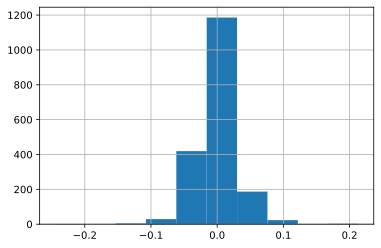

In [17]:
# Now let's try an LSTM to predict returns
vale3['Return'].hist()

In [19]:
series = vale3['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [20]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1842, 10, 1) Y.shape (1842,)


In [21]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)

model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
29/29 [==============================] - 1s 18ms/step - loss: 1.0126 - val_loss: 0.8221
Epoch 2/80
29/29 [==============================] - 0s 7ms/step - loss: 1.0118 - val_loss: 0.8121
Epoch 3/80
29/29 [==============================] - 0s 7ms/step - loss: 1.0029 - val_loss: 0.8125
Epoch 4/80
29/29 [==============================] - 0s 8ms/step - loss: 0.9988 - val_loss: 0.8193
Epoch 5/80
29/29 [==============================] - 0s 8ms/step - loss: 0.9932 - val_loss: 0.8187
Epoch 6/80
29/29 [==============================] - 0s 8ms/step - loss: 0.9900 - val_loss: 0.8248
Epoch 7/80
29/29 [==============================] - 0s 8ms/step - loss: 0.9859 - val_loss: 0.8266
Epoch 8/80
29/29 [==============================] - 0s 7ms/step - loss: 0.9780 - val_loss: 0.8355
Epoch 9/80
29/29 [==============================] - 0s 8ms/step - loss: 0.9706 - val_loss: 0.8377
Epoch 10/80
29/29 [==============================] - 0s 8ms/step - loss: 0.9807 - val_loss: 0.8536
Epoch 11/80
29/29 

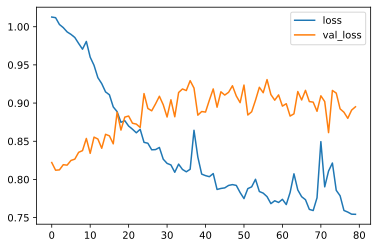

In [22]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1842, 1)


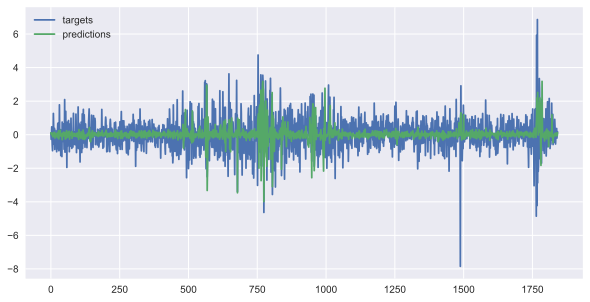

In [28]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.style.use('seaborn')

plt.figure(figsize=(10, 5))

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

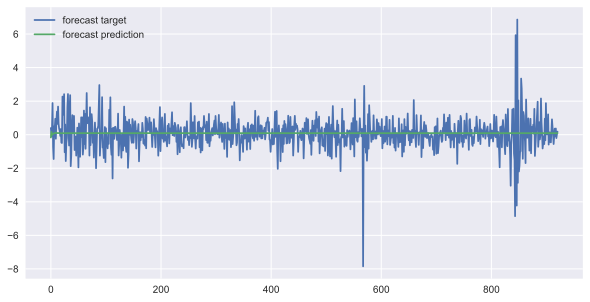

In [29]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
    # update the predictions list
    validation_predictions.append(p)
  
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.figure(figsize=(10, 5))    

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### 2. Classificação Binária

E se a abordagem passar a ser um problema de classificação binária? Estaremos apenas interessados em saber se os retornos irão ser positivos ou negativos.

In [31]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = vale3[['open', 'high', 'low', 'close', 'volume']].values
targets = vale3['Return'].values

In [50]:
# Now make the actual data which will go into the neural network
T = 50 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [51]:
# Normalização das Entradas (Volume com valores muito maiores que os demais)
Ntrain = len(input_data) * 2 // 3 # Treinar com os primeiros 2/3 dos dados
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [52]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
    X_train[t, :, :] = input_data[t:t+T]
    Y_train[t] = (targets[t+T] > 0)

In [53]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
    # u counts from 0...(N - Ntrain)
    # t counts from Ntrain...N
    t = u + Ntrain
    X_test[u, :, :] = input_data[t:t+T]
    Y_test[u] = (targets[t+T] > 0)

In [54]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(500)(i)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [55]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
39/39 [==============================] - 1s 25ms/step - loss: 0.7040 - accuracy: 0.4777 - val_loss: 0.6988 - val_accuracy: 0.4859
Epoch 2/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6937 - accuracy: 0.5182 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 3/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6938 - accuracy: 0.5036 - val_loss: 0.6949 - val_accuracy: 0.4982
Epoch 4/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6943 - accuracy: 0.4947 - val_loss: 0.6947 - val_accuracy: 0.5106
Epoch 5/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6939 - accuracy: 0.4988 - val_loss: 0.6939 - val_accuracy: 0.5106
Epoch 6/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6939 - accuracy: 0.4931 - val_loss: 0.6957 - val_accuracy: 0.5035
Epoch 7/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6950 - val_accuracy: 0.4982
Epoch 

39/39 [==============================] - 1s 18ms/step - loss: 0.6952 - accuracy: 0.5247 - val_loss: 0.6993 - val_accuracy: 0.5335
Epoch 59/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6969 - accuracy: 0.5166 - val_loss: 0.7090 - val_accuracy: 0.4859
Epoch 60/300
39/39 [==============================] - 1s 19ms/step - loss: 0.7019 - accuracy: 0.4915 - val_loss: 0.7006 - val_accuracy: 0.5176
Epoch 61/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6984 - accuracy: 0.5036 - val_loss: 0.6908 - val_accuracy: 0.5158
Epoch 62/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6960 - accuracy: 0.4988 - val_loss: 0.7075 - val_accuracy: 0.4842
Epoch 63/300
39/39 [==============================] - 1s 19ms/step - loss: 0.7011 - accuracy: 0.4899 - val_loss: 0.6928 - val_accuracy: 0.5123
Epoch 64/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6997 - accuracy: 0.5028 - val_loss: 0.7166 - val_accuracy: 0.4824
Epoch 65/300

39/39 [==============================] - 1s 18ms/step - loss: 0.6926 - accuracy: 0.5101 - val_loss: 0.6979 - val_accuracy: 0.4859
Epoch 116/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6940 - accuracy: 0.4915 - val_loss: 0.7003 - val_accuracy: 0.4912
Epoch 117/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6933 - accuracy: 0.5069 - val_loss: 0.6976 - val_accuracy: 0.4894
Epoch 118/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6948 - accuracy: 0.4955 - val_loss: 0.6970 - val_accuracy: 0.4912
Epoch 119/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6936 - accuracy: 0.4972 - val_loss: 0.6945 - val_accuracy: 0.4894
Epoch 120/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6930 - accuracy: 0.5142 - val_loss: 0.6977 - val_accuracy: 0.4859
Epoch 121/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6942 - accuracy: 0.5045 - val_loss: 0.6999 - val_accuracy: 0.4877
Epoch 

Epoch 172/300
39/39 [==============================] - 1s 23ms/step - loss: 0.6907 - accuracy: 0.5352 - val_loss: 0.7137 - val_accuracy: 0.5141
Epoch 173/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6927 - accuracy: 0.5206 - val_loss: 0.7086 - val_accuracy: 0.4824
Epoch 174/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6841 - accuracy: 0.5579 - val_loss: 0.7203 - val_accuracy: 0.5106
Epoch 175/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6906 - accuracy: 0.5255 - val_loss: 0.7221 - val_accuracy: 0.5176
Epoch 176/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6918 - accuracy: 0.5344 - val_loss: 0.7366 - val_accuracy: 0.4947
Epoch 177/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6893 - accuracy: 0.5215 - val_loss: 0.7136 - val_accuracy: 0.5018
Epoch 178/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6877 - accuracy: 0.5328 - val_loss: 0.7018 - val_accuracy:

Epoch 229/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6840 - accuracy: 0.5368 - val_loss: 0.7321 - val_accuracy: 0.4842
Epoch 230/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6845 - accuracy: 0.5490 - val_loss: 0.7230 - val_accuracy: 0.4982
Epoch 231/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6820 - accuracy: 0.5344 - val_loss: 0.7385 - val_accuracy: 0.4947
Epoch 232/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6842 - accuracy: 0.5498 - val_loss: 0.8519 - val_accuracy: 0.4982
Epoch 233/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6880 - accuracy: 0.5304 - val_loss: 0.7728 - val_accuracy: 0.4648
Epoch 234/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6866 - accuracy: 0.5296 - val_loss: 0.7413 - val_accuracy: 0.4965
Epoch 235/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6902 - accuracy: 0.5134 - val_loss: 0.7714 - val_accuracy:

Epoch 286/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6817 - accuracy: 0.5417 - val_loss: 0.9095 - val_accuracy: 0.4842
Epoch 287/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6965 - accuracy: 0.5166 - val_loss: 0.7380 - val_accuracy: 0.4894
Epoch 288/300
39/39 [==============================] - 1s 18ms/step - loss: 0.6917 - accuracy: 0.5352 - val_loss: 0.6935 - val_accuracy: 0.5053
Epoch 289/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6896 - accuracy: 0.5490 - val_loss: 0.7057 - val_accuracy: 0.4894
Epoch 290/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6881 - accuracy: 0.5304 - val_loss: 0.7203 - val_accuracy: 0.5141
Epoch 291/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6893 - accuracy: 0.5271 - val_loss: 0.7004 - val_accuracy: 0.4930
Epoch 292/300
39/39 [==============================] - 1s 19ms/step - loss: 0.6865 - accuracy: 0.5490 - val_loss: 0.6921 - val_accuracy:

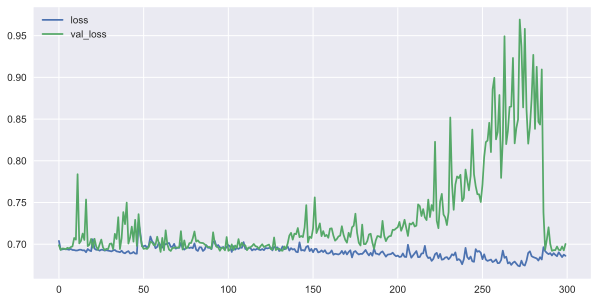

In [56]:
# plot the loss
plt.figure(figsize=(10, 5))  

# Overfitting
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

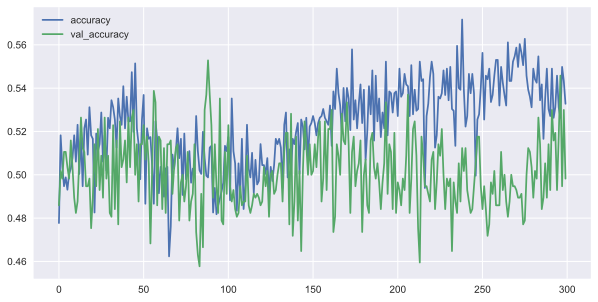

In [57]:
# Plot accuracy per iteration
plt.figure(figsize=(10, 5))  

plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

---